# Music Recommendation on Yahoo! Dataset

In [0]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.cluster.hierarchy import dendrogram, linkage
from lightfm import LightFM
from lightfm.datasets import fetch_movielens
from lightfm.evaluation import precision_at_k
from lightfm.evaluation import auc_score
from scipy.cluster.hierarchy import dendrogram, linkage

C:\Users\tanay\Anaconda3\lib\site-packages\lightfm\_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn('LightFM was compiled without OpenMP support. '


**Taking only ratings where songs were rated 5**

In [0]:
df_train=pd.read_table("R5",header=0,delimiter =",",index_col=0)
df_test=pd.read_table("test-R5",header=0,delimiter =",",index_col=0)

C:\Users\tanay\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:472: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [0]:
df_test.head()

,userId,songId,Rating
0,0,7171,5
3,0,35821,5
4,0,82446,5
5,0,90409,5
6,0,107410,5


In [0]:
df_tall=pd.read_table("data/train_0.txt")

In [0]:
df_small=pd.read_table("data/test_0.txt",names=['userId','songId','Rating'])

In [0]:
df_t45=df_small.query('Rating >= 4')

In [0]:
df_train.shape

(76344626, 3)

In [0]:
df_train.head()

,userId,songId,Rating
0,0,166,5
7,0,16794,5
8,0,17821,5
10,0,27331,5
11,0,32438,5


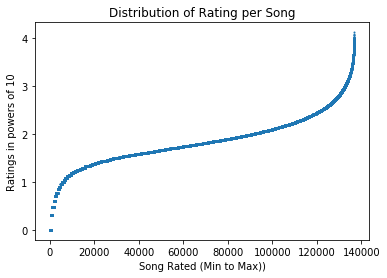

In [0]:
songvals=pd.DataFrame(df_train["songId"].value_counts())
vals=(sorted(songvals.values))
plt.scatter(sorted(songvals.index),np.log10(vals),s=1)
plt.title("Distribution of Rating per Song")
plt.xlabel("Song Rated (Min to Max))")
plt.ylabel("Ratings in powers of 10")
plt.show()

**Number of songs in Train that aren't present in Test**

In [0]:
del1=df_t45['songId'].isin(df_train['songId'])
del2=df_train['songId'].isin(df_t45['songId'])
df_t45=df_t45.drop(df_t45[(del1)==False].index)
df_train=df_train.drop(df_train[(del2)==False].index)

In [0]:
df_t45.shape

(1125089, 3)

In [0]:
len(df_t45.iloc[:8821].songId.value_counts())

6562

In [0]:
len(df_train[:1000000].songId.value_counts())

95379

In [0]:
df_train.head()

,userId,songId,Rating
0,0,166,5
7,0,16794,5
8,0,17821,5
10,0,27331,5
11,0,32438,5


In [0]:
pvttest = df_t45.query('userId <= 8818').pivot(index='userId',columns='songId',values='Rating').fillna(0).astype(int)

In [0]:
test=scipy.sparse.csr_matrix(pvttest) 

In [0]:
pivot1 = df_train[:1000000].pivot(index='userId',columns='songId',values='Rating').fillna(0).astype(int)

In [0]:
df=scipy.sparse.csr_matrix(pivot1) 

 **pivot1.columns contains the list of all unique songs, which are features for our model**


In [0]:
songatt=pd.read_table("data/song-attributes.txt",names=["songId","albumId","artistId","genreId"])

In [0]:
genre=pd.read_table("data/genre-hierarchy.txt",names=["genreId","parentgId","level","genreName"])

In [0]:
songdesc=pd.merge(songatt, genre, on='genreId')

In [0]:
#We use different loss functions to build different models, compare results, print results for
#the best one. - Available loss functions are warp, logistic, bpr, and warp-kos.



#Provide the Music features
#then print out the recommended results 

def song_recommendation(data,user_ids,lossf,n):
    
    #create model
    model = LightFM(loss=lossf)
    #train model
    model.fit(data, epochs=70, num_threads=4)


    #number of users and songs in training data
    n_users, n_items = data.shape

    #generate recommendations for each user we input
    for user_id in user_ids:

        #songs they already like
        known_positives = df_train.query('userId == '+str(user_id))['songId']

        #songs our model predicts they will like
        scores = model.predict(user_id, np.arange(n_items))

        #rank them in order of most liked to least
        top_items = pivot1.columns[np.argsort(-scores)]

        #print out the results
        print("User %s" % user_id)
        print("     Known positives:")

        for x in known_positives[:n]:
            print(   songdesc.query('songId =='+str(x)))

        print("     Recommended:")

        for x in top_items[:n]:
            print(  songdesc.query('songId =='+str(x)))

In [0]:
song_recommendation(df,list(set(df_train.userId))[:10],'warp',10)

User 0
     Known positives:
     songId  albumId  artistId  genreId  parentgId  level genreName
141     166     5303      7231        0          0      1   Unknown
       songId  albumId  artistId  genreId  parentgId  level genreName
14570   16794     2517      7620        0          0      1   Unknown
        songId  albumId  artistId  genreId  parentgId  level     genreName
134174   17821     8620      2020      135        134      2  Classic Rock
       songId  albumId  artistId  genreId  parentgId  level genreName
23703   27331    15761      3551        0          0      1   Unknown
       songId  albumId  artistId  genreId  parentgId  level genreName
28093   32438    15761       579        0          0      1   Unknown
       songId  albumId  artistId  genreId  parentgId  level genreName
30282   34995    15761      1842        0          0      1   Unknown
       songId  albumId  artistId  genreId  parentgId  level genreName
45454   52539    15761      1842        0          0   

User 3
     Known positives:
        songId  albumId  artistId  genreId  parentgId  level genreName
118480    3844    18613      6918      134        134      1      Rock
        songId  albumId  artistId  genreId  parentgId  level genreName
128756    7002    14662      4009      114        114      1       R&B
        songId  albumId  artistId  genreId  parentgId  level genreName
128763    7258    13892      7847      114        114      1       R&B
      songId  albumId  artistId  genreId  parentgId  level genreName
7826    9006     1765      1974        0          0      1   Unknown
        songId  albumId  artistId  genreId  parentgId  level genreName
125873    9008    13358      3029      106        106      1       Pop
       songId  albumId  artistId  genreId  parentgId  level genreName
10346   11941     1765      1974        0          0      1   Unknown
       songId  albumId  artistId  genreId  parentgId  level genreName
12216   14078    19162      4293        0          0   

User 7
     Known positives:
       songId  albumId  artistId  genreId  parentgId  level genreName
35579   41104    13137      1988        0          0      1   Unknown
       songId  albumId  artistId  genreId  parentgId  level genreName
46533   53758    14565      6187        0          0      1   Unknown
       songId  albumId  artistId  genreId  parentgId  level genreName
63797   73729    13137      1988        0          0      1   Unknown
       songId  albumId  artistId  genreId  parentgId  level genreName
92545  106935    16679        29        0          0      1   Unknown
        songId  albumId  artistId  genreId  parentgId  level genreName
102637  118620     1190      7019        0          0      1   Unknown
     Recommended:
       songId  albumId  artistId  genreId  parentgId  level genreName
35875   41458     7580      5606        0          0      1   Unknown
       songId  albumId  artistId  genreId  parentgId  level genreName
20416   23550    10382      3265        0

In [0]:
df.shape

(8328, 113899)

In [0]:
song_recommendation(df,list(set(df_train.userId))[:10],'warp-kos',10)

User 0
     Known positives:
     songId  albumId  artistId  genreId  parentgId  level genreName
141     166     5303      7231        0          0      1   Unknown
       songId  albumId  artistId  genreId  parentgId  level genreName
14570   16794     2517      7620        0          0      1   Unknown
        songId  albumId  artistId  genreId  parentgId  level     genreName
134174   17821     8620      2020      135        134      2  Classic Rock
       songId  albumId  artistId  genreId  parentgId  level genreName
23703   27331    15761      3551        0          0      1   Unknown
       songId  albumId  artistId  genreId  parentgId  level genreName
28093   32438    15761       579        0          0      1   Unknown
       songId  albumId  artistId  genreId  parentgId  level genreName
30282   34995    15761      1842        0          0      1   Unknown
       songId  albumId  artistId  genreId  parentgId  level genreName
45454   52539    15761      1842        0          0   

User 3
     Known positives:
        songId  albumId  artistId  genreId  parentgId  level genreName
118480    3844    18613      6918      134        134      1      Rock
        songId  albumId  artistId  genreId  parentgId  level genreName
128756    7002    14662      4009      114        114      1       R&B
        songId  albumId  artistId  genreId  parentgId  level genreName
128763    7258    13892      7847      114        114      1       R&B
      songId  albumId  artistId  genreId  parentgId  level genreName
7826    9006     1765      1974        0          0      1   Unknown
        songId  albumId  artistId  genreId  parentgId  level genreName
125873    9008    13358      3029      106        106      1       Pop
       songId  albumId  artistId  genreId  parentgId  level genreName
10346   11941     1765      1974        0          0      1   Unknown
       songId  albumId  artistId  genreId  parentgId  level genreName
12216   14078    19162      4293        0          0   

User 7
     Known positives:
       songId  albumId  artistId  genreId  parentgId  level genreName
35579   41104    13137      1988        0          0      1   Unknown
       songId  albumId  artistId  genreId  parentgId  level genreName
46533   53758    14565      6187        0          0      1   Unknown
       songId  albumId  artistId  genreId  parentgId  level genreName
63797   73729    13137      1988        0          0      1   Unknown
       songId  albumId  artistId  genreId  parentgId  level genreName
92545  106935    16679        29        0          0      1   Unknown
        songId  albumId  artistId  genreId  parentgId  level genreName
102637  118620     1190      7019        0          0      1   Unknown
     Recommended:
       songId  albumId  artistId  genreId  parentgId  level genreName
31641   36561     4237      4701        0          0      1   Unknown
        songId  albumId  artistId  genreId  parentgId  level genreName
113856  131629     6362      7548       

In [0]:
song_recommendation(df,list(set(df_train.userId))[:10],'logistic',10)

User 0
     Known positives:
     songId  albumId  artistId  genreId  parentgId  level genreName
141     166     5303      7231        0          0      1   Unknown
       songId  albumId  artistId  genreId  parentgId  level genreName
14570   16794     2517      7620        0          0      1   Unknown
        songId  albumId  artistId  genreId  parentgId  level     genreName
134174   17821     8620      2020      135        134      2  Classic Rock
       songId  albumId  artistId  genreId  parentgId  level genreName
23703   27331    15761      3551        0          0      1   Unknown
       songId  albumId  artistId  genreId  parentgId  level genreName
28093   32438    15761       579        0          0      1   Unknown
       songId  albumId  artistId  genreId  parentgId  level genreName
30282   34995    15761      1842        0          0      1   Unknown
       songId  albumId  artistId  genreId  parentgId  level genreName
45454   52539    15761      1842        0          0   

User 3
     Known positives:
        songId  albumId  artistId  genreId  parentgId  level genreName
118480    3844    18613      6918      134        134      1      Rock
        songId  albumId  artistId  genreId  parentgId  level genreName
128756    7002    14662      4009      114        114      1       R&B
        songId  albumId  artistId  genreId  parentgId  level genreName
128763    7258    13892      7847      114        114      1       R&B
      songId  albumId  artistId  genreId  parentgId  level genreName
7826    9006     1765      1974        0          0      1   Unknown
        songId  albumId  artistId  genreId  parentgId  level genreName
125873    9008    13358      3029      106        106      1       Pop
       songId  albumId  artistId  genreId  parentgId  level genreName
10346   11941     1765      1974        0          0      1   Unknown
       songId  albumId  artistId  genreId  parentgId  level genreName
12216   14078    19162      4293        0          0   

User 7
     Known positives:
       songId  albumId  artistId  genreId  parentgId  level genreName
35579   41104    13137      1988        0          0      1   Unknown
       songId  albumId  artistId  genreId  parentgId  level genreName
46533   53758    14565      6187        0          0      1   Unknown
       songId  albumId  artistId  genreId  parentgId  level genreName
63797   73729    13137      1988        0          0      1   Unknown
       songId  albumId  artistId  genreId  parentgId  level genreName
92545  106935    16679        29        0          0      1   Unknown
        songId  albumId  artistId  genreId  parentgId  level genreName
102637  118620     1190      7019        0          0      1   Unknown
     Recommended:
       songId  albumId  artistId  genreId  parentgId  level genreName
12025   13859    14384      2927        0          0      1   Unknown
       songId  albumId  artistId  genreId  parentgId  level genreName
80420   92881    10504      4488        0

In [0]:
song_recommendation(df,list(set(df_train.userId))[:10],'bpr',10)

User 0
     Known positives:
     songId  albumId  artistId  genreId  parentgId  level genreName
141     166     5303      7231        0          0      1   Unknown
       songId  albumId  artistId  genreId  parentgId  level genreName
14570   16794     2517      7620        0          0      1   Unknown
        songId  albumId  artistId  genreId  parentgId  level     genreName
134174   17821     8620      2020      135        134      2  Classic Rock
       songId  albumId  artistId  genreId  parentgId  level genreName
23703   27331    15761      3551        0          0      1   Unknown
       songId  albumId  artistId  genreId  parentgId  level genreName
28093   32438    15761       579        0          0      1   Unknown
       songId  albumId  artistId  genreId  parentgId  level genreName
30282   34995    15761      1842        0          0      1   Unknown
       songId  albumId  artistId  genreId  parentgId  level genreName
45454   52539    15761      1842        0          0   

User 3
     Known positives:
        songId  albumId  artistId  genreId  parentgId  level genreName
118480    3844    18613      6918      134        134      1      Rock
        songId  albumId  artistId  genreId  parentgId  level genreName
128756    7002    14662      4009      114        114      1       R&B
        songId  albumId  artistId  genreId  parentgId  level genreName
128763    7258    13892      7847      114        114      1       R&B
      songId  albumId  artistId  genreId  parentgId  level genreName
7826    9006     1765      1974        0          0      1   Unknown
        songId  albumId  artistId  genreId  parentgId  level genreName
125873    9008    13358      3029      106        106      1       Pop
       songId  albumId  artistId  genreId  parentgId  level genreName
10346   11941     1765      1974        0          0      1   Unknown
       songId  albumId  artistId  genreId  parentgId  level genreName
12216   14078    19162      4293        0          0   

User 7
     Known positives:
       songId  albumId  artistId  genreId  parentgId  level genreName
35579   41104    13137      1988        0          0      1   Unknown
       songId  albumId  artistId  genreId  parentgId  level genreName
46533   53758    14565      6187        0          0      1   Unknown
       songId  albumId  artistId  genreId  parentgId  level genreName
63797   73729    13137      1988        0          0      1   Unknown
       songId  albumId  artistId  genreId  parentgId  level genreName
92545  106935    16679        29        0          0      1   Unknown
        songId  albumId  artistId  genreId  parentgId  level genreName
102637  118620     1190      7019        0          0      1   Unknown
     Recommended:
       songId  albumId  artistId  genreId  parentgId  level genreName
63797   73729    13137      1988        0          0      1   Unknown
       songId  albumId  artistId  genreId  parentgId  level genreName
24005   27683     4890      2171        0

In [0]:
df_test.query('userId == 10')['songId']

3081      3844
3090      8589
3096     12314
3111     28986
3124     42781
3140     56885
3151     68476
3154     71481
3156     71706
3174     81200
3178     87592
3214    113883
3219    115649
3245    127282
Name: songId, dtype: int64

In [0]:
df_test.query('userId == 10')['songId']

105    54923
Name: songId, dtype: int64

### Model Evaluation

**WARP**

In [0]:
NUM_THREADS = 2
NUM_COMPONENTS = 30
NUM_EPOCHS = 3
ITEM_ALPHA = 1e-6

# Now we fit a WARP model: these generally have the best performance.
model = LightFM(loss='warp',
                item_alpha=ITEM_ALPHA,
               no_components=NUM_COMPONENTS)

# Running 3 epochs and time it.
%time model = model.fit(df, epochs=NUM_EPOCHS, num_threads=NUM_THREADS)

Wall time: 18.4 s


In [0]:
train_precision = precision_at_k(model, df, k=10).mean()

train_auc = auc_score(model, df).mean()

print('Precision: train %.2f' % train_precision)
print('AUC: train %.2f' % train_auc)

Precision: train 0.14
AUC: train 0.95


**BPR**

In [0]:
# Now we fit a BPR model: these generally have the best performance.
model = LightFM(loss='bpr',
                item_alpha=ITEM_ALPHA,
               no_components=NUM_COMPONENTS)

# Running 3 epochs and time it.
%time model = model.fit(df, epochs=NUM_EPOCHS, num_threads=NUM_THREADS)

train_precision = precision_at_k(model, df, k=10).mean()

train_auc = auc_score(model, df).mean()

print('Precision: train %.2f' % train_precision)
print('AUC: train %.2f' % train_auc)

Wall time: 23.9 s
Precision: train 0.10
AUC: train 0.79


**Logistic**

In [0]:
# Now we fit a BPR model: these generally have the best performance.
model = LightFM(loss='logistic',
                item_alpha=ITEM_ALPHA,
               no_components=NUM_COMPONENTS)

# Running 3 epochs and time it.
%time model = model.fit(df, epochs=NUM_EPOCHS, num_threads=NUM_THREADS)

train_precision = precision_at_k(model, df, k=10).mean()

train_auc = auc_score(model, df).mean()

print('Precision: train %.2f' % train_precision)
print('AUC: train %.2f' % train_auc)

Wall time: 15.8 s
Precision: train 0.06
AUC: train 0.88


**Warp-Kos**

In [0]:
# Now we fit a BPR model: these generally have the best performance.
model = LightFM(loss='warp-kos',
                item_alpha=ITEM_ALPHA,
               no_components=NUM_COMPONENTS)

# Running 3 epochs and time it.
%time model = model.fit(df, epochs=NUM_EPOCHS, num_threads=NUM_THREADS)

train_precision = precision_at_k(model, df, k=10).mean()

train_auc = auc_score(model, df).mean()

print('Precision: train %.2f' % train_precision)
print('AUC: train %.2f' % train_auc)

Wall time: 25.2 s
Precision: train 0.15
AUC: train 0.90


### Conclusion

**Warp loss** gives us the best Precision and Train AUC in the least time to fit, therefore it's the best model for our dataset.